In [ ]:
# import relevant libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cv2
from skimage.feature import graycomatrix, graycoprops
import torch
import torchvision
import torchvision.transforms as transforms

import os
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Function for extracting features from the given image

**Color Features:**

https://docs.opencv.org/4.x/annotated.html

https://docs.opencv.org/3.4/d2/d96/tutorial_py_table_of_contents_imgproc.html

**Texture:**

https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html

https://medium.com/@girishajmera/feature-extraction-of-images-using-glcm-gray-level-cooccurrence-matrix-e4bda8729498

**Shape:**

https://docs.opencv.org/3.4/d2/d96/tutorial_py_table_of_contents_imgproc.html

In [ ]:
import torchvision.transforms as T
import torch.nn.functional as F
def extract_features(image):  # compatible for gpu
    # Ensure image is on the correct device
    device = image.device

    # Convert to grayscale
    gray = T.Grayscale()(image)  # Shape: (1, 224, 224)

    # 1. Color Features (Mean & Std of HSV)
    hsv = T.ColorJitter()(image)  # Simulate HSV-like variation (PyTorch lacks direct HSV conversion)
    mean_hue = torch.mean(hsv[0, :, :])
    std_hue = torch.std(hsv[0, :, :])
    mean_sat = torch.mean(hsv[1, :, :])
    std_sat = torch.std(hsv[1, :, :])
    mean_val = torch.mean(hsv[2, :, :])
    std_val = torch.std(hsv[2, :, :])

    # 2. Texture Features
    gray_np = gray.squeeze().cpu().numpy().astype('uint8')  # Convert for skimage GLCM
    glcm = graycomatrix(gray_np, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]
    entropy = -torch.sum(torch.tensor(glcm) * torch.log2(torch.tensor(glcm) + 1e-10)).item()

    # 3. Shape Features
    gray_np = (gray.squeeze() * 255).byte().cpu().numpy()
    _, thresh = cv2.threshold(gray_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        asymmetry = 0
        circularity = 0
        solidity = 0
        roughness = 0
        aspect_ratio = 0
    else:
      cnt = max(contours, key=cv2.contourArea)
      area = cv2.contourArea(cnt)
      perimeter = cv2.arcLength(cnt, True)
      circularity = (4 * torch.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

      hull = cv2.convexHull(cnt)
      hull_area = cv2.contourArea(hull)
      solidity = area / hull_area if hull_area != 0 else 0
      roughness = perimeter / torch.sqrt(torch.tensor(area, device=device)) if area != 0 else 0

      if len(cnt) >= 5:
          ellipse = cv2.fitEllipse(cnt)
          major_axis, minor_axis = ellipse[1]
          aspect_ratio = major_axis / minor_axis if minor_axis != 0 else 0
      else:
          aspect_ratio = 0

    # Compute asymmetry
    h, w = thresh.shape
    flipped_horiz = cv2.flip(thresh, 1)
    flipped_vert = cv2.flip(thresh, 0)
    diff_horiz = torch.sum(torch.tensor(abs(thresh - flipped_horiz), device=device)) / torch.sum(torch.tensor(thresh, device=device))
    diff_vert = torch.sum(torch.tensor(abs(thresh - flipped_vert), device=device)) / torch.sum(torch.tensor(thresh, device=device))
    asymmetry = (diff_horiz + diff_vert) / 2

    # Return all features as a tensor on GPU
    return torch.tensor([mean_hue, mean_sat, mean_val, std_hue, std_sat, std_val, contrast, homogeneity, energy, entropy,
                         asymmetry, circularity, solidity, roughness, aspect_ratio], device=device)

# KNN

1. Extract relevant features of the input sample and store in a vector
2. The KNN predicts the class of the sample by selecting the majority class of the sample's k nearest neighbors based on the sample's feature vector.

"Training" is done by computing the feature vectors for the set of "training" samples. During evaluation, a new sample is classified based on it's distance to it's k nearest pre-computed feature vectors.

For example, a sample has feature vector X. The algo finds k pre-computed feature vectors that are "closest" to X and determines which class is most common among these k vectors. X is then assigned to this class.

In [ ]:
# ---------------------
# 1. Data Preprocessing & Augmentation (split first, then augment only train) CODE FROM TEST2 (Suyeon)
# ---------------------
def create_dataloaders(batch_size, dataset_path):
    #dataset_path = os.path.join(os.getcwd(), "ISIC_Data")

    # Reduced (more realistic) train augmentations
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),             # Slightly larger resize
        transforms.RandomCrop(224),                # Then random crop
        transforms.RandomHorizontalFlip(p=0.5),    # Horizontal flip
        transforms.RandomRotation(degrees=15),     # Mild rotation
        transforms.ColorJitter(brightness=0.2,
                               contrast=0.2,
                               saturation=0.2,
                               hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Validation and test data: only resize + center or fixed crop, no heavy augmentation
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load the full dataset WITHOUT transform initially
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=None)
    print(f"Total dataset size: {len(full_dataset)} images")

    # Group images by class
    class_samples = defaultdict(list)
    for idx, (img_path, label) in enumerate(full_dataset.samples):
        class_samples[label].append(idx)

    # Ensure exactly 2360 images per class
    fixed_indices = []
    min_samples = 2360  # Fixed count

    # for label, indices in class_samples.items():
    #     fixed_indices.extend(random.sample(indices, min_samples))  # Downsample

    for label, indices in class_samples.items():
        # Sample up to min_samples, but not more than the available indices
        num_to_sample = min(min_samples, len(indices))
        fixed_indices.extend(random.sample(indices, num_to_sample))  # Downsample

    # Shuffle selected indices before splitting
    random.shuffle(fixed_indices)

    # Split into 80% train, 10% val, 10% test
    split1 = int(0.8 * len(fixed_indices))
    split2 = int(0.9 * len(fixed_indices))

    train_indices = fixed_indices[:split1]
    val_indices = fixed_indices[split1:split2]
    test_indices = fixed_indices[split2:]

    # Create Subsets
    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)
    test_subset = Subset(full_dataset, test_indices)

    # Assign transforms
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_subset.dataset.transform = val_test_transform

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

In [ ]:
# ALTERNATIVE CODE FOR GETTING DATA LOADERS (FROM CINDY)
from torch.utils.data.sampler import SubsetRandomSampler
def get_data_loader(dataset, batch_size, num_workers=2):
    """Splits the dataset into training (80%), validation (10%), and testing (10%) sets.

    Args:
        dataset: torchvision dataset object.
        batch_size: Number of samples per batch.
        num_workers: Number of workers for data loading.

    Returns:
        train_loader, val_loader, test_loader, class_names
    """
    class_names = ['benign', 'melanoma', 'bcc', 'scc']  # Manually defined class names

    # Generate shuffled indices
    total_size = len(dataset)
    indices = list(range(total_size))

    generator = torch.Generator()
    generator.manual_seed(1000)  # Ensure reproducibility
    np.random.shuffle(indices)

    # Compute dataset splits
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size  # Ensures sum = total_size

    # Assign indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices, generator=generator)
    val_sampler = SubsetRandomSampler(val_indices, generator=generator)
    test_sampler = SubsetRandomSampler(test_indices, generator=generator)

    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

    return train_loader, val_loader, test_loader, class_names

In [ ]:
def get_features(dataloader, features, labels, device):
  i = 0
  length = len(dataloader)
  for image_batch, labels_batch in dataloader:
    if(i % 500 == 0):
      print(f"Batch: {i}/{length}")

    image_batch = image_batch.to(device)  # Move the entire batch to GPU
    # Process each image in the batch
    for image, label in zip(image_batch, labels_batch):
        extracted_features = extract_features(image)
        features.append(extracted_features)
        labels.append(label)
    i += 1

  return np.array(features), np.array(labels)

In [ ]:
######### Load data into training, validation, and test sets #############
dataset_path = "/content/drive/My Drive/APS 360 project/ISIC_Data"

#### ignore  ###
# Resize + Normalization
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize for RGB images
# ])

# Load dataset
#dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
### ignore ###

# Preallocate arrays
num_features = 15
batch_size = 100
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

########### Compute features for each image ##############
# train_loader, val_loader, test_loader, class_names = get_data_loader(dataset, batch_size=1)
train_loader, val_loader, test_loader = create_dataloaders(batch_size, dataset_path)
training_features, training_labels, val_features, val_labels, test_features, test_labels= [], [], [], [], [], []

print("Got data loaders. Extracting features")
training_features, training_labels = get_features(train_loader, training_features, training_labels, device)
print("Done getting training data features")
val_features, val_labels = get_features(val_loader, val_features, val_labels, device)
print("Done getting val data features")
test_features, test_labels = get_features(test_loader, test_features, test_labels, device)
print("Done getting test data features")

#save
np.save("training_features.npy",training_features)
np.save("training_labels.npy", training_labels)
np.save("val_features.npy",val_features)
np.save("val_labels.npy", val_labels)
np.save("test_features.npy",test_features)
np.save("test_features.npy", test_labels)

print("Done extracting features")

########### Create training, validation, and test splits from feature vectors #########
# normalize features
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Tune hyperparameters (k value) using validation data
best_k = 1
best_acc = 0
for k in range(1, 200, 2):  # Test odd values of k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(training_features, training_labels)
    label_val_pred = knn.predict(val_features)
    acc = accuracy_score(val_labels, label_val_pred) # compare real and predicted labels and calculate accuracy
    if acc > best_acc:
        best_acc = acc
        best_k = k
print("Done validation. Best K: ", best_k)

Total dataset size: 4518 images
Got data loaders. Extracting features
Batch: 0/37
Done getting training data features
Batch: 0/5
Done getting val data features
Batch: 0/5
Done getting test data features
Done extracting features
Done validation. Best K:  37


In [ ]:
# Build and evaluate final tuned model on test set
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(training_features, training_labels)
test_predictions = knn_final.predict(test_features)
print(f"Final Test Accuracy: {100*accuracy_score(test_labels, test_predictions):.4f}%")


Final Test Accuracy: 59.7345%


# Visualize Results

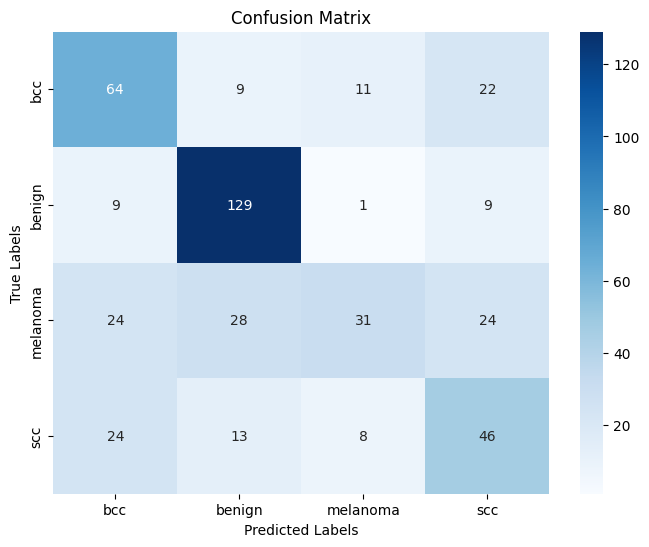

In [ ]:
# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
# cm = confusion_matrix(test_labels, test_predictions)

# # Plot it
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix for KNN Model")
# plt.show()

# Confusion matrix
class_names = test_loader.dataset.dataset.classes  # Because we used Subset
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(test_labels, test_predictions, target_names=test_loader.dataset.dataset.classes))

              precision    recall  f1-score   support

         bcc       0.53      0.60      0.56       106
      benign       0.72      0.87      0.79       148
    melanoma       0.61      0.29      0.39       107
         scc       0.46      0.51      0.48        91

    accuracy                           0.60       452
   macro avg       0.58      0.57      0.56       452
weighted avg       0.60      0.60      0.58       452



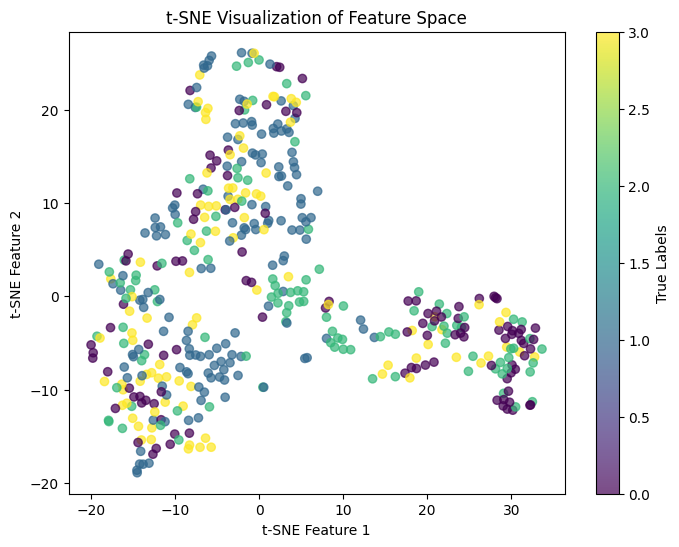

In [ ]:
from sklearn.manifold import TSNE
X_test = test_features
# Reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_test_2D = tsne.fit_transform(X_test)

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=test_labels, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="True Labels")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.title("t-SNE Visualization of Feature Space")
plt.show()

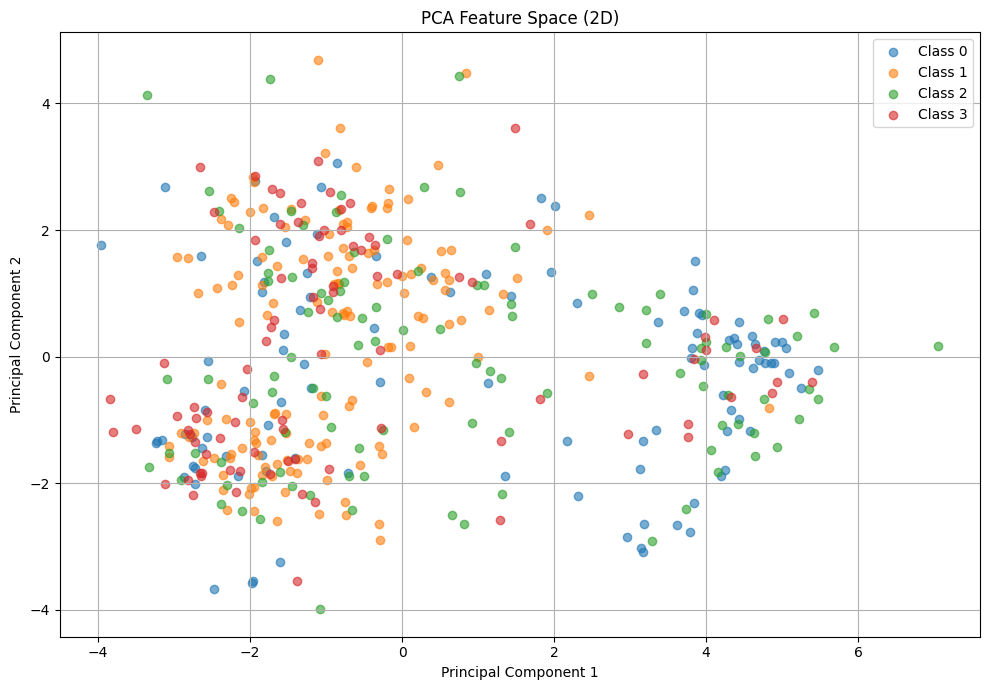

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize features (very important for PCA!)
X_test = test_features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

# Run PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-reduced features
plt.figure(figsize=(10, 7))

y=test_labels
unique_labels = np.unique(y)
for label in unique_labels:
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f"Class {label}", alpha=0.6)

plt.title("PCA Feature Space (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
